In [1]:
import mxnet as mx
import matplotlib.pyplot as plt
from skimage import io
from model import get_network
from util import output_embedding,load_model,get_kitty_data_dir

import time
import numpy as np
%matplotlib inline
import cv2

In [2]:
def pred(num,left_dir,right_dir,dis_range):  
    begin = time.time()
    ctx = mx.gpu(3)
    left,right,left_pred,right_pred = output_embedding(left_dir,right_dir,308)
    dis_pred = np.zeros((left_pred.shape[1],left_pred.shape[2]))
    
    plt.figure()
    plt.subplot(211)
    io.imshow(left)
    
    for y in range(left_pred.shape[1]):
        left_embedding = mx.nd.array(left_pred[:,y].T,ctx)
        right_embedding = mx.nd.array(right_pred[:,y],ctx)
        tmp = mx.nd.dot(left_embedding,right_embedding).asnumpy()
        for x in range(left_pred.shape[2]):
            if x - dis_range <0:
                t = 0
            else:
                t = x - dis_range
            dis_pred[y,x] = tmp[x,t:x+1][::-1].argmax()
    
    plt.subplot(212)
    io.imshow(dis_pred)
    plt.xticks()
    plt.title("%f s" % (time.time() - begin),loc='right',)
    plt.axis('off')
    plt.savefig("./pred/%d" % num)

In [ ]:
img_dir = get_kitty_data_dir(175,194)
for i,img in enumerate(img_dir):
    pred(i,img[1],img[2],40)

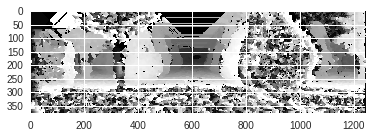

In [86]:
window_size = 16
left = io.imread('./colored_0/000009_10.png')
right = io.imread('./colored_1/000009_10.png')
stereo = cv2.StereoSGBM(minDisparity = 0,
        numDisparities = 32,
        SADWindowSize = 8,
        P1 = 2,
        P2 = 32,
        disp12MaxDiff = 50,
        uniquenessRatio = 1,
        speckleWindowSize = 30,
        speckleRange = 6)
disparity = stereo.compute(left,right)
io.imshow(disparity)